In [1]:
import os
import math
from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve, auc

from src.experiment import train_federated, train_separated, create_models
from src.pipelines import dataset_drift, dataset_outliers, dataset_hidden_outliers
from src.utils import parse_filename, normalize, sliding_window

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.models import Model

import matplotlib as mpl
from matplotlib import gridspec
import matplotlib.pyplot as plt
import seaborn as sns
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = r'\usepackage{libertine}'
mpl.rc('font', family='serif')

In [2]:
data_name = "10_150_100_0.2_1_0.02_0.6_0.2_local_d.npy"
out_name = "10_150_100_0.2_1_0.02_0.6_0.2_local_o.npy"
data = np.load(os.path.join(os.getcwd(), "data", "synth", data_name))
data = normalize(data)
is_outlier = np.load(os.path.join(os.getcwd(), "data", "synth", out_name))
params = parse_filename(data_name)

In [3]:
num_devices = params["num_devices"]
dims = params["dims"]
subspace_frac = ["subspace_frac"]
frac_outlying_devices = params["frac_outlying_devices"]
frac_outlying_data = params["frac_outlying_data"]
compression_factor = 0.2
num_data = data.shape[1]
outlier_type = params["outlier_type"]

window_size = 10
T = data.shape[1]
T_pretraining = 50

In [4]:
# TRAINING CONFIG
frac_available = 1.0
batch_size = window_size
epochs = 1

client_ids = np.arange(num_devices)
models_fed = create_models(num_devices, dims, compression_factor)
models_sep = create_models(num_devices, dims, compression_factor)

In [5]:
print("PRE TRAINING")
for t in tqdm(range(window_size, T_pretraining)):
    window_data = data[:, sliding_window(t, window_size)]
    models_fed = train_federated(models_fed, 
                                 window_data, 
                                 epochs=1, batch_size=batch_size, 
                                 frac_available=frac_available)
    models_sep = train_separated(models_sep, 
                                 window_data, 
                                 epochs=1, batch_size=batch_size)

  0%|          | 0/40 [00:00<?, ?it/s]

PRE TRAINING


100%|██████████| 40/40 [06:43<00:00, 10.10s/it]


In [6]:
print("START MONITORING")
predictions_fed = np.array([])
predictions_sep = np.array([])
start = T_pretraining
end = T
for t in tqdm(np.arange(start, end)):
    # move sliding window
    window_data = data[:, sliding_window(t, window_size)]
    # get the new observation from the data
    new_observations = window_data[:, -1:]
    # check new observation
    new_predictions_fed = np.array([model.predict(new_observations[i]) for i, model in enumerate(models_fed)])
    new_predictions_sep = np.array([model.predict(new_observations[i]) for i, model in enumerate(models_sep)])
    predictions_fed = new_predictions_fed if t == start else np.concatenate((predictions_fed, new_predictions_fed), axis=1)
    predictions_sep = new_predictions_sep if t == start else np.concatenate((predictions_sep, new_predictions_sep), axis=1)
    # train models on slinding window
    models_fed = train_federated(models_fed, 
                                 window_data, 
                                 epochs=1, batch_size=batch_size, 
                                 frac_available=frac_available)
    models_sep = train_separated(models_sep, 
                                 window_data, 
                                 epochs=1, batch_size=batch_size)

  0%|          | 0/100 [00:00<?, ?it/s]

START MONITORING


100%|██████████| 100/100 [24:47<00:00, 14.87s/it]


In [7]:
n = 10  # how many digits we will display
fig = plt.figure(figsize=(20, 5))
for i in range(n):
    m = int(math.sqrt(dims))
    test = data[i][-1].reshape(m, m)
    out = is_outlier[i][-1].reshape(m, m)
    prediction = predictions[i][0].reshape(m, m)

    # display original
    ax = plt.subplot(4, n, i + 1)
    plt.imshow(test, cmap="Blues")
    ax.get_xaxis().set_visible(False)
    ax.set_title("Device {}".format(i))
    if i == 0:
        ax.set_ylabel("original")
    else:
        ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(4, n, i + 1 + n)
    plt.imshow(prediction, cmap="Blues")
    ax.get_xaxis().set_visible(False)
    if i == 0:
        ax.set_ylabel("generated")
    else:
        ax.get_yaxis().set_visible(False)

        # display reconstruction
    diff = np.abs(test - prediction)
    ax = plt.subplot(4, n, i + 1 + 2 * n)
    plt.imshow(diff, cmap="Blues")
    ax.get_xaxis().set_visible(False)
    if i == 0:
        ax.set_ylabel("difference")
    else:
        ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(4, n, i + 1 + 3 * n)
    plt.imshow(out, cmap="Blues")
    ax.get_xaxis().set_visible(False)
    if i == 0:
        ax.set_ylabel("outliers")
    else:
        ax.get_yaxis().set_visible(False)

plt.tight_layout()
plt.show()


NameError: name 'predictions' is not defined

<Figure size 1440x360 with 0 Axes>

(10, 100, 100)
(10, 100, 100)


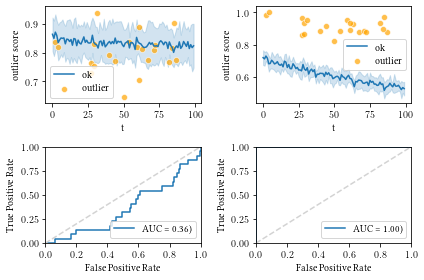

In [8]:
print(predictions_fed.shape)
print(data[:, T_pretraining:].shape)

diff_fed = np.abs(data[:, T_pretraining:] - predictions_fed)
dist_fed = np.linalg.norm(diff_fed, axis=-1)
diff_sep = np.abs(data[:, T_pretraining:] - predictions_sep)
dist_sep = np.linalg.norm(diff_sep, axis=-1)
dist_fed = dist_fed/np.max(dist_fed)
dist_sep = dist_sep/np.max(dist_sep)
labels = is_outlier[:, T_pretraining:].any(axis=-1)


plt.subplot(221)

# ugly but working
io = []
nio = []
for i, row in enumerate(dist_fed):
    for j, val in enumerate(row):
        if labels[i][j]:
            nio.append([j, val])
        else:
            io.append([j, val])
io = pd.DataFrame(io)
nio = pd.DataFrame(nio)

sns.lineplot(io[0], io[1], label="ok", ci="sd", err_style="band")
sns.scatterplot(nio[0], nio[1], label="outlier", color="orange", alpha=0.7)
plt.xlabel("t")
plt.ylabel("outlier score")
plt.legend()

plt.legend()

plt.subplot(223)

fpr, tpr, thresholds = roc_curve(labels.flatten(), dist_fed.flatten())
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label='AUC = %0.2f)' % roc_auc)
plt.xlim((0,1))
plt.ylim((0,1))
plt.plot([0, 1], [0, 1], color='lightgray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title('ROC Autoencoder 100-80-100 ReLU/Sigmoid synth\_multidim\_100\_000')
plt.legend(loc="lower right")

plt.subplot(222)

# ugly but working
io = []
nio = []
for i, row in enumerate(dist_sep):
    for j, val in enumerate(row):
        if labels[i][j]:
            nio.append([j, val])
        else:
            io.append([j, val])
io = pd.DataFrame(io)
nio = pd.DataFrame(nio)

sns.lineplot(io[0], io[1], label="ok", ci="sd", err_style="band")
sns.scatterplot(nio[0], nio[1], label="outlier", color="orange", alpha=0.7)
plt.xlabel("t")
plt.ylabel("outlier score")
plt.legend()

plt.legend()

plt.subplot(224)

fpr, tpr, thresholds = roc_curve(labels.flatten(), dist_sep.flatten())
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label='AUC = %0.2f)' % roc_auc)
plt.xlim((0,1))
plt.ylim((0,1))
plt.plot([0, 1], [0, 1], color='lightgray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title('ROC Autoencoder 100-80-100 ReLU/Sigmoid synth\_multidim\_100\_000')
plt.legend(loc="lower right")

plt.tight_layout()
plt.savefig(os.path.join(os.getcwd(), "figures", "results", "fedstream_{}.pdf".format(outlier_type)))